# ADL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).

# Submission Date: 05.01.2025
Submit the already-run notebook.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

# EX1. PCA dimensionality reduction (10pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import random

def perform_PCA(X, n_components):
  """
  Implement the PCA algorithm.
  Input: X [numpy array] - shape: (N,784)
  Output: Projected data using n_components
  """

  scaler = StandardScaler()
  X_standardized = scaler.fit_transform(X)


  covariance_matrix = np.cov(X_standardized, rowvar=False)


  eigenvalues, eigenvectors = eigh(covariance_matrix)


  sorted_indices = np.argsort(eigenvalues)[::-1]
  top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]

  X_projected = np.matmul(X_standardized, top_eigenvectors)

  return X_projected


def plot_projected_data(X, y, method='PCA'):

  plt.figure(figsize=(10, 8))

  cmap = plt.get_cmap('viridis', 10)


  scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.7, edgecolor='k')

  cbar = plt.colorbar(scatter, ticks=np.arange(10))
  cbar.set_label("Class Labels")
  cbar.set_ticklabels([str(i) for i in range(10)])

  plt.title(f"2D Projection of Data using {method}")
  plt.xlabel("Principal Component 1")
  plt.ylabel("Principal Component 2")
  plt.grid(alpha=0.3)
  plt.show()


In [ ]:
# For EX5, Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

np.random.seed(42)

# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)

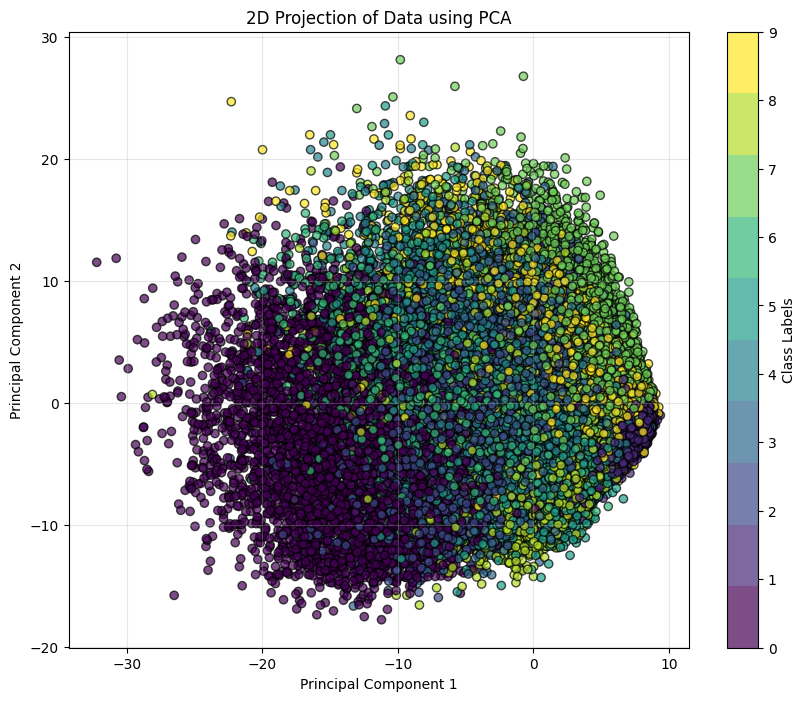

In [ ]:
### Your code goes here ###
n_components = 2
X_projected = perform_PCA(train_subset.dataset.data.numpy().reshape(-1, 784), n_components)
plot_projected_data(X_projected, train_subset.dataset.targets.numpy())

# EX2 Autoencoder (AE) (15pts)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2.
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [ ]:
class MLP_AE(nn.Module):
    def __init__(self):
      super(MLP_AE, self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(28*28, 256),
          nn.ReLU(),
          nn.Linear(256, 2)
      )
      self.decoder = nn.Sequential(
          nn.Linear(2, 256),
          nn.ReLU(),
          nn.Linear(256, 784),
      )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [ ]:
### Your code goes here ###
def train(model, train_loader, criterion, optimizer, epochs=25, cuda=False):
    model.train()
    if cuda:
      model.cuda()
    loss_list = []
    with tqdm(total=epochs, unit="epoch", position=0, leave=True) as pbar:
      for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            if cuda:
              images = images.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))
        pbar.set_postfix(loss=running_loss/len(train_loader))
        pbar.update(1)
        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    plot_loss(loss_list)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  plt.plot(loss_list)
  plt.grid()
  plt.ylabel("MSE")
  plt.xlabel("Epochs")
  plt.title("MSE Loss")

In [ ]:
# Initialize the model, loss function, and optimizer
model_ae_mlp_nl =  MLP_AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae_mlp_nl.parameters(), lr=0.001)
print(model_ae_mlp_nl)

MLP_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
  )
)


  0%|          | 0/50 [00:00<?, ?epoch/s]

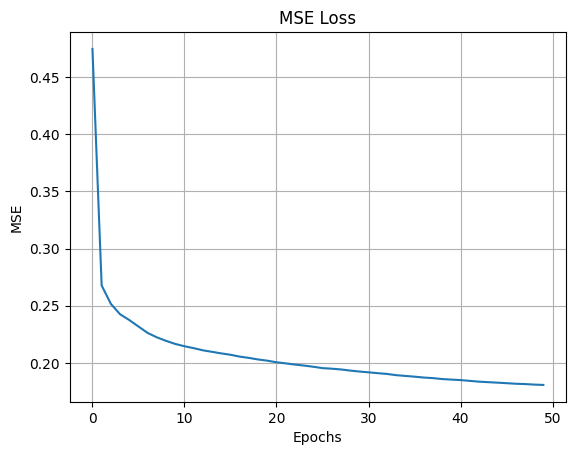

In [ ]:
train(model_ae_mlp_nl, trainloader, criterion, optimizer,  epochs=50)

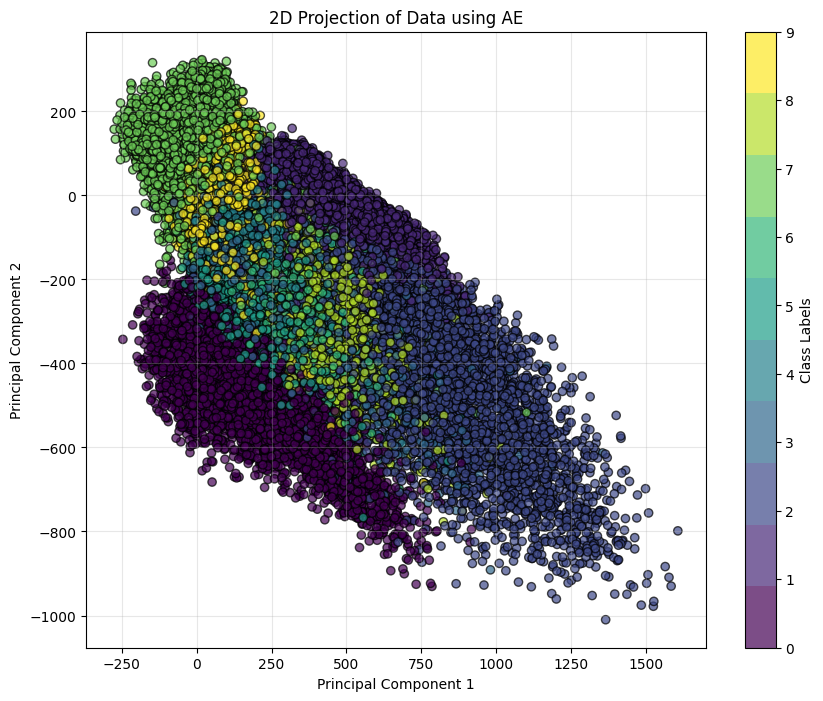

In [ ]:
n_components = 2
X_projected = model_ae_mlp_nl.encoder(train_subset.dataset.data.view(-1, 784).float()).detach().numpy()
plot_projected_data(X_projected, train_subset.dataset.targets.numpy(), 'AE')

# EX3 Linear Autoencoder (15pts)
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [ ]:
class Linear_AE(nn.Module):
    def __init__(self):
      super(Linear_AE, self).__init__()
      self.encoder =nn.Sequential(
          nn.Linear(28*28, 256),
          nn.Linear(256, 2)
      )
      self.decoder = nn.Sequential(
          nn.Linear(2, 256),
          nn.Linear(256, 784)
      )
    def forward(self,x):
      x = x.view(-1, 784)
      x = self.encoder(x)
      x = self.decoder(x)
      x = x.view(-1, 1, 28, 28)
      return x

In [ ]:
model_ae_mlp_lin =  Linear_AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae_mlp_lin.parameters(), lr=0.001)
print(model_ae_mlp_lin)

Linear_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=784, bias=True)
  )
)


  0%|          | 0/50 [00:00<?, ?epoch/s]

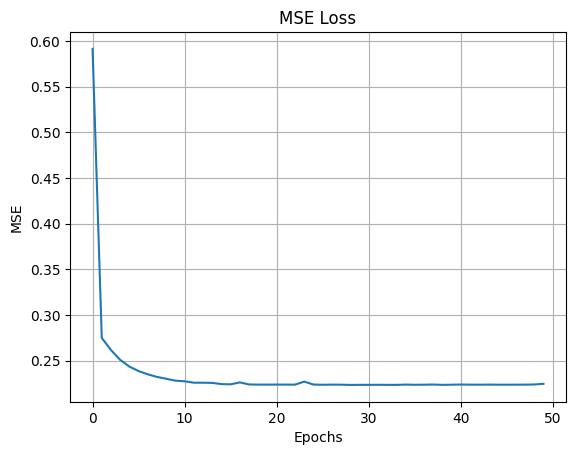

In [ ]:
### Your code goes here ###
train(model_ae_mlp_lin, trainloader, criterion, optimizer,  epochs=50)

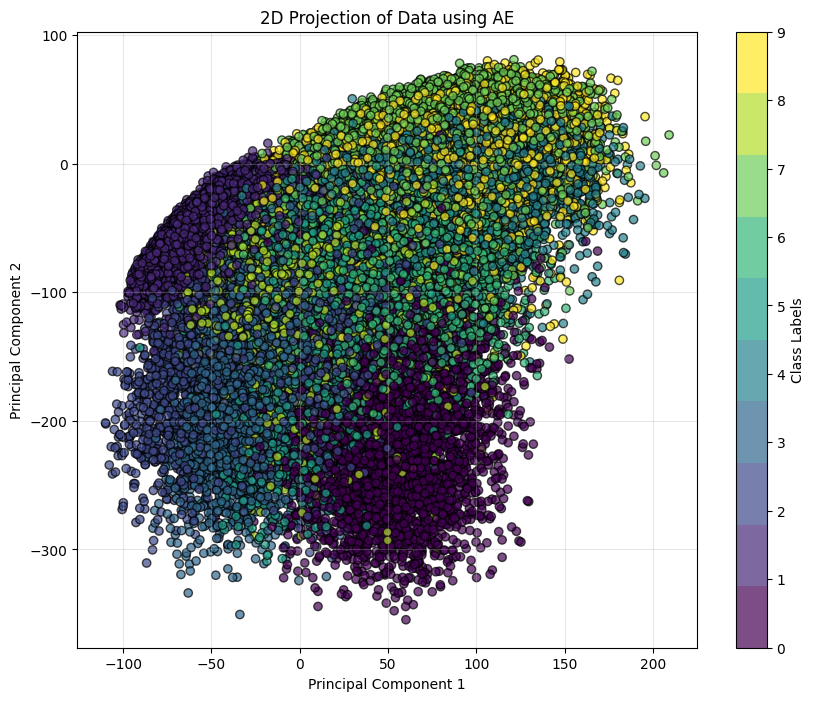

In [ ]:
n_components = 2
X_projected = model_ae_mlp_lin.encoder(train_subset.dataset.data.view(-1, 784).float()).detach().numpy()
plot_projected_data(X_projected, train_subset.dataset.targets.numpy(), 'AE')

# EX 4 - Discussion (10pts)
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


In [ ]:
def plot_projected_data_side_by_side(X_list, y, methods):
    """
    Plot the 2D projections of data side-by-side using subplots.

    Parameters:
    - X_list: List of 2D projected data arrays (each with shape (n_samples, 2)).
    - y: Array of class labels (shape (n_samples,)).
    - methods: List of method names corresponding to the projections in X_list.
    """
    n_methods = len(X_list)
    fig, axes = plt.subplots(1, n_methods, figsize=(15, 5))

    for i, (X, method) in enumerate(zip(X_list, methods)):
        ax = axes[i] if n_methods > 1 else axes
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
        ax.set_title(f"2D Projection using {method}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()


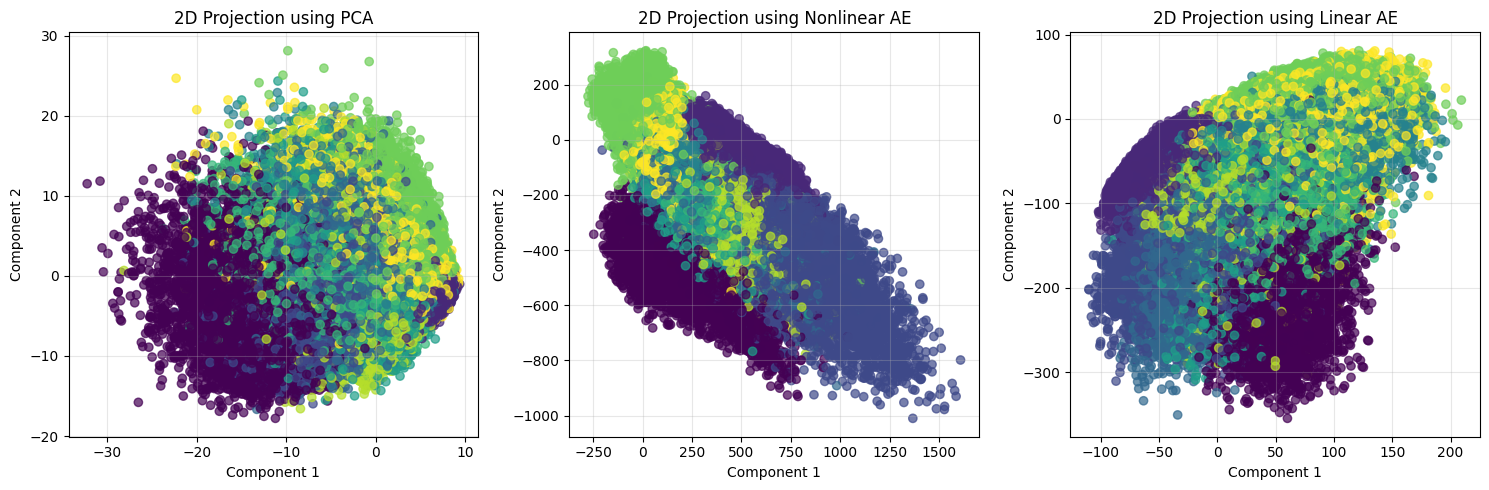

In [ ]:
X_pca = perform_PCA(train_subset.dataset.data.numpy().reshape(-1, 784), n_components)
X_ae = model_ae_mlp_nl.encoder(train_subset.dataset.data.view(-1, 784).float()).detach().numpy()
X_linear_ae = model_ae_mlp_lin.encoder(train_subset.dataset.data.view(-1, 784).float()).detach().numpy()
y=train_subset.dataset.targets.numpy()
plot_projected_data_side_by_side([X_pca, X_ae, X_linear_ae], y, methods=['PCA', 'Nonlinear AE', 'Linear AE'])

# Discussion - Answer
**answer** -> Linear AE shows similar results to PCA but with slight differences due to optimization nuances, but both of them are linear.

non-Linear AE gives best results among those options due to its abillity to capture more intricate, non-linear structures

```
# This is formatted as code
```



# EX 5 - Denoising AE and Classification (50pts.)
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project (not google drive dir) and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You **may not re-train** the classification network or train a new model for classification task.

There is **no need** to submit the trained model weights.

### Grading for this section:
```python
50pts = max(cleaned image accuracy + 10, 100)*0.5 #(i.e, accuracy >= 90% will give you a full grade).
```

You will also be evaluated on the quality of your code and apporach.

## Load trained model

In [2]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda")

mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<ipython-input-2-fb02e975912a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<All keys matched successfully>

## Data and functions

In [3]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    noise = torch.randn(images.size(),  device=images.device) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # False for clean images, True for corrupted/noisy
            images, labels = images.to(device), labels.to(device)
            if add_noise:
              images = add_gaussian_noise(images)
            # Denoise the image before the classifier
            if denoise_model is not None:
              images = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [4]:
# For EX5, Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

np.random.seed(42)

# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=512, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.66MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Compute and print test accuracy for clean and corrupted images
test_acc_clean = compute_accuracy(mlp_clf, testloader)
test_acc_corrupted = compute_accuracy(mlp_clf, testloader, add_noise=True)
print(f"Test Accuracy for Clean Images: {test_acc_clean:.2f}%")
print(f"Test Accuracy for Corrupted Images: {test_acc_corrupted:.2f}%")


Test Accuracy for Clean Images: 93.98%
Test Accuracy for Corrupted Images: 59.55%


In [5]:
class ConvDenoisingAE(nn.Module):
    """
    A simple convolutional autoencoder designed to remove noise from MNIST images.
    Architecture:
        - Encoder:
            Conv2d -> ReLU -> Conv2d -> ReLU
        - Decoder:
            ConvTranspose2d -> ReLU -> ConvTranspose2d -> Tanh
    """
    def __init__(self):
        super(ConvDenoisingAE, self).__init__()

          # ----------- Encoder -----------
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            # Final shape: [B, 128, 2, 2]
        )

        # ----------- Decoder -----------
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3,
                               stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,
                               stride=1, padding=1, output_padding=0),

            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3,
                               stride=2, padding=1, output_padding=1),

            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3,
                               stride=2, padding=1, output_padding=1),

            nn.Tanh()
        )

    def forward(self, x):
        # x: [B, 1, 28, 28]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)  # -> [B, 1, 28, 28]
        return decoded

In [5]:
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  plt.plot(loss_list)
  plt.grid()
  plt.ylabel("MSE")
  plt.xlabel("Epochs")
  plt.title("MSE Loss")

def train(model, train_loader, criterion, optimizer, epochs=25):
    model.train()
    loss_list = []

    with tqdm(total=epochs, unit='epoch' , position=0, leave=True) as pbar:
        for epoch in range(epochs):
            running_loss = 0.0
            for images, _ in train_loader:
                images = images.to(device)
                noisy_images = add_gaussian_noise(images)

                optimizer.zero_grad()
                outputs = model(noisy_images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            loss_list.append(running_loss / len(train_loader))
            pbar.set_postfix(loss=running_loss / len(train_loader))
            pbar.update(1)

    plot_loss(loss_list)


In [6]:
# Function to denoise images
def denoise(noisy_images, model=None):
    model.eval()
    with torch.no_grad():
        cleaned_images = model(noisy_images)
    return cleaned_images

# Function to plot original, noisy, and cleaned images
def plot_results(model, test_loader, n_samples=5):
    unique_images = []
    unique_labels = set()

    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() not in unique_labels:
                unique_images.append((img, label.item()))
                unique_labels.add(label.item())
            if len(unique_labels) == n_samples:
                break
        if len(unique_labels) == n_samples:
            break

    # Prepare images
    images = torch.stack([img for img, _ in unique_images])
    labels = [label for _, label in unique_images]
    noisy_images = add_gaussian_noise(images)
    cleaned_images = denoise(noisy_images, model)

    # Plot results
    fig, axes = plt.subplots(n_samples, 3, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original: {labels[i]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Noisy Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(cleaned_images[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Cleaned Image')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


  0%|          | 0/400 [00:00<?, ?epoch/s]

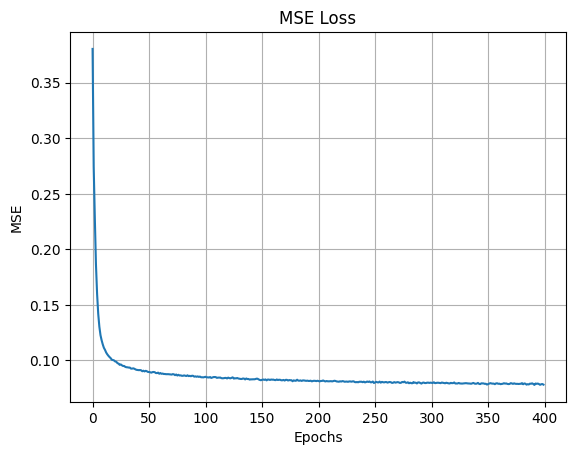

In [8]:
denoise_model = ConvDenoisingAE()
denoise_model = denoise_model.to('cuda')

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(denoise_model.parameters(), lr=1e-3, weight_decay=1e-5)

train(denoise_model, trainloader, criterion, optimizer, epochs=400)

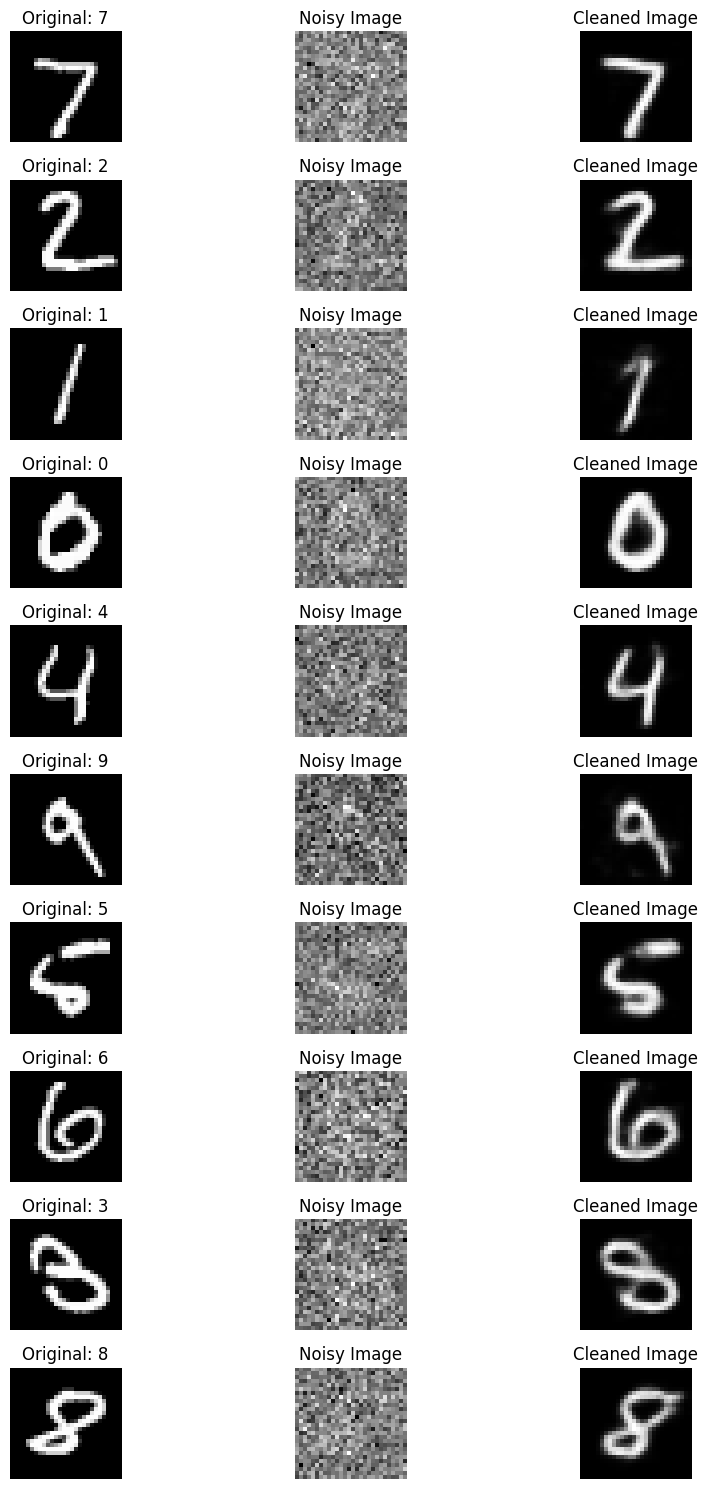

In [22]:
plot_results(denoise_model, testloader, n_samples=10)

In [19]:
res=0
for _ in range(5):
  res+= compute_accuracy(mlp_clf, testloader, denoise_model=denoise_model, add_noise=True)
test_acc_corrupted = res/5

print(f"Test Accuracy for Corrupted Images: {test_acc_corrupted:.2f}%")


Test Accuracy for Corrupted Images: 88.03%
